In [74]:
# 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 colab 경우 Runtime > Restart session 필요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Font directories:
	/root/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/root/.fonts
	/usr/share/fonts/truetype
	/usr/share/fonts/truetype/dejavu
	/usr/share/fonts/truetype/nanum
/root/.local/share/fonts: skipping, no such directory
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detecte

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats as stats
from scipy.stats import shapiro

mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용

## data

In [50]:
df_ksearch_date = pd.read_csv("Keyword_search_by_date.csv")
df_Nvisitors_Date = pd.read_csv("Number_of_visitors_date.csv")
df_search_trend = pd.read_csv("Trend_search_date.csv")

In [51]:
df_ksearch_date

,_id,destination_type,destination_search,region,std_year,std_month,std_year_month
0,65e92d9cbb908e26c804031e,전체,1937279,강원,2020,1,202001
1,65e92d9cbb908e26c804031f,전체,1395025,강원,2020,2,202002
2,65e92d9cbb908e26c8040320,전체,1295467,강원,2020,3,202003
3,65e92d9cbb908e26c8040321,전체,1592147,강원,2020,4,202004
4,65e92d9cbb908e26c8040322,전체,2286676,강원,2020,5,202005
...,...,...,...,...,...,...,...
8155,65e92d9dbb908e26c80422f9,문화관광,80761,충북,2023,12,202312
8156,65e92d9dbb908e26c80422fa,역사관광,20072,충북,2023,12,202312
8157,65e92d9dbb908e26c80422fb,자연관광,25920,충북,2023,12,202312
8158,65e92d9dbb908e26c80422fc,체험관광,11141,충북,2023,12,202312


In [52]:
df_Nvisitors_Date

,_id,industry_major_cate,std_year_month,std_year,std_month,consumption_amount,region
0,65e932a1bb908e26c804492e,전체,202012,2020,12,59888524,강원
1,65e932a1bb908e26c804492f,전체,202001,2020,1,98147222,강원
2,65e932a1bb908e26c8044930,전체,202002,2020,2,69547139,강원
3,65e932a1bb908e26c8044931,전체,202003,2020,3,62071229,강원
4,65e932a1bb908e26c8044932,전체,202004,2020,4,75022238,강원
...,...,...,...,...,...,...,...
5688,65e932a2bb908e26c8045f66,여가서비스업,202305,2023,5,19760050,충북
5689,65e932a2bb908e26c8045f67,쇼핑업,202305,2023,5,21217701,충북
5690,65e932a2bb908e26c8045f68,여행업,202305,2023,5,10149,충북
5691,65e932a2bb908e26c8045f69,숙박업,202305,2023,5,3267158,충북


## 전처리

In [79]:
# 카테고리 값 통일화
df_Nvisitors_Date['industry_major_cate'] = df_Nvisitors_Date['industry_major_cate'].replace({
    '숙박업': '숙박',
    '식음료업': '음식',
    '쇼핑업': '쇼핑'
})
df_ksearch_query = df_ksearch_date.query('destination_type == "전체" or destination_type == "숙박" or destination_type == "음식" or destination_type == "쇼핑"')
df_Nvisitors_query = df_Nvisitors_Date.query('industry_major_cate == "전체" or industry_major_cate == "숙박" or industry_major_cate == "음식" or industry_major_cate == "쇼핑"')

In [54]:
# 병합
df_Nvisitors_query['destination_type'] = df_Nvisitors_query['industry_major_cate']

/tmp/ipykernel_79/545279499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Nvisitors_query['destination_type'] = df_Nvisitors_query['industry_major_cate']


In [57]:
merged_df = pd.merge(df_ksearch_query, df_Nvisitors_query, on=['std_year_month', 'std_year', 'std_month', 'region', 'destination_type'], how='inner')
merged_df

,_id_x,destination_type,destination_search,region,std_year,std_month,std_year_month,_id_y,industry_major_cate,consumption_amount
0,65e92d9cbb908e26c804031e,전체,1937279,강원,2020,1,202001,65e932a1bb908e26c804492f,전체,98147222
1,65e92d9cbb908e26c804031f,전체,1395025,강원,2020,2,202002,65e932a1bb908e26c8044930,전체,69547139
2,65e92d9cbb908e26c8040320,전체,1295467,강원,2020,3,202003,65e932a1bb908e26c8044931,전체,62071229
3,65e92d9cbb908e26c8040321,전체,1592147,강원,2020,4,202004,65e932a1bb908e26c8044932,전체,75022238
4,65e92d9cbb908e26c8040322,전체,2286676,강원,2020,5,202005,65e932a1bb908e26c8044933,전체,103414222
...,...,...,...,...,...,...,...,...,...,...
3259,65e92d9dbb908e26c80422ee,숙박,145420,충북,2023,11,202311,65e932a2bb908e26c8045f34,숙박,3400345
3260,65e92d9dbb908e26c80422ef,음식,479126,충북,2023,11,202311,65e932a2bb908e26c8045f37,음식,48224831
3261,65e92d9dbb908e26c80422f6,쇼핑,67532,충북,2023,12,202312,65e932a2bb908e26c8045f3b,쇼핑,20269791
3262,65e92d9dbb908e26c80422f7,숙박,120634,충북,2023,12,202312,65e932a2bb908e26c8045f3a,숙박,3122998


## 가설 1 : 키워드 검색량과 관광지 소비랑(방문객 수) 간에 상관 관계가 있을 것이다.

- 귀무 가설 : 키워드 검색량과 관광지 소비랑(방문객 수) 간에 상관 관계가 없다.
- 대립 가설 : 키워드 검색량과 관광지 소비랑(방문객 수) 간에 상관 관계가 있다.

In [80]:
# 데이터 정규성 검정
stat, p = shapiro(merged_df['destination_search'].dropna())
print('검정 통계량(statistic): %.3f, p-value: %.3f' % (stat, p))

# p-value에 따른 결론
alpha = 0.05
if p > alpha:
    print('p-value가 유의수준보다 크므로 데이터는 정규 분포를 따릅니다.')
else:
    print('p-value가 유의수준보다 작으므로 데이터는 정규 분포를 따르지 않습니다.')

검정 통계량(statistic): 0.497, p-value: 0.000
p-value가 유의수준보다 작으므로 데이터는 정규 분포를 따르지 않습니다.


In [81]:
# 데이터 정규성 검정
stat, p = shapiro(merged_df['consumption_amount'].dropna())
print('검정 통계량(statistic): %.3f, p-value: %.3f' % (stat, p))

# p-value에 따른 결론
alpha = 0.05
if p > alpha:
    print('p-value가 유의수준보다 크므로 데이터는 정규 분포를 따릅니다.')
else:
    print('p-value가 유의수준보다 작으므로 데이터는 정규 분포를 따르지 않습니다.')

검정 통계량(statistic): 0.521, p-value: 0.000
p-value가 유의수준보다 작으므로 데이터는 정규 분포를 따르지 않습니다.


둘 다 비정규 분포이므로 -> spearmanr

In [69]:
stats.spearmanr(merged_df['destination_search'], merged_df['consumption_amount'])

SignificanceResult(statistic=0.8631067847857828, pvalue=0.0)

- SignificanceResult(statistic=0.8631067847857828, pvalue=0.0)

### 분석 결과
- 통계 결론 : pvalue가 0.05보다 작으므로 -> 귀무가설 기각
- 사실 결론 : 키워드 검색량과 관광지 방문객수 간에 상관 관계가 있다.

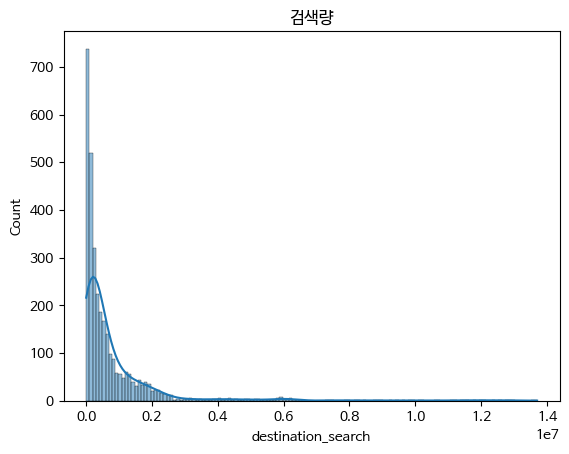

In [76]:
sns.histplot(data=merged_df, x='destination_search', kde=True)
plt.title("검색량")
plt.show()

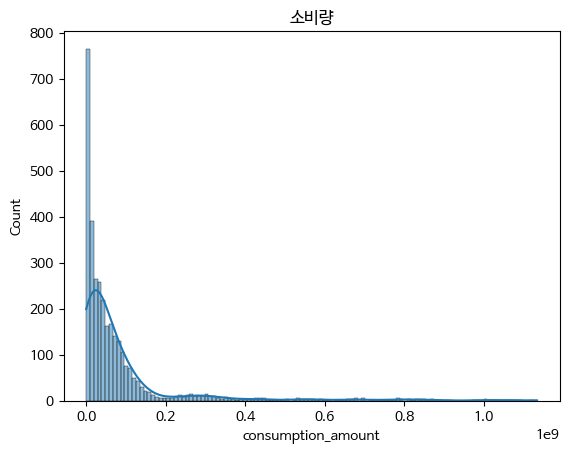

In [77]:
sns.histplot(data=merged_df, x='consumption_amount', kde=True)
plt.title("소비량")
plt.show()

## 가설 2 : 계절에 따라 카테고리별 소비량에 차이가 있을 것이다.
- 귀무 가설 : 계절에 따라 카테고리별 소비량에 차이가 없다.
- 대립 가설 : 계절에 따라 카테고리별 소비량에 차이가 있다.

In [83]:
seasons = {
    12: '겨울', 1: '겨울', 2: '겨울',
    3: '봄', 4: '봄', 5: '봄',
    6: '여름', 7: '여름', 8: '여름',
    9: '가을', 10: '가을', 11: '가을'
}
df_Nvisitors_Date['season'] = df_Nvisitors_Date['std_month'].map(seasons)

In [88]:
df_Nvisitors_Date

,_id,industry_major_cate,std_year_month,std_year,std_month,consumption_amount,region,season
0,65e932a1bb908e26c804492e,전체,202012,2020,12,59888524,강원,겨울
1,65e932a1bb908e26c804492f,전체,202001,2020,1,98147222,강원,겨울
2,65e932a1bb908e26c8044930,전체,202002,2020,2,69547139,강원,겨울
3,65e932a1bb908e26c8044931,전체,202003,2020,3,62071229,강원,봄
4,65e932a1bb908e26c8044932,전체,202004,2020,4,75022238,강원,봄
...,...,...,...,...,...,...,...,...
5688,65e932a2bb908e26c8045f66,여가서비스업,202305,2023,5,19760050,충북,봄
5689,65e932a2bb908e26c8045f67,쇼핑,202305,2023,5,21217701,충북,봄
5690,65e932a2bb908e26c8045f68,여행업,202305,2023,5,10149,충북,봄
5691,65e932a2bb908e26c8045f69,숙박,202305,2023,5,3267158,충북,봄


In [86]:
df_Nvisitors_Date['season'].value_counts()

season
겨울    1425
봄     1423
가을    1423
여름    1422
Name: count, dtype: int64

In [84]:
# 데이터 정규성 검정  shapiro test
stat, p = shapiro(df_Nvisitors_Date['consumption_amount'].dropna())
print('검정 통계량(statistic): %.3f, p-value: %.3f' % (stat, p))

# p-value에 따른 결론
alpha = 0.05
if p > alpha:
    print('p-value가 유의수준보다 크므로 데이터는 정규 분포를 따릅니다.')
else:
    print('p-value가 유의수준보다 작으므로 데이터는 정규 분포를 따르지 않습니다.')

검정 통계량(statistic): 0.423, p-value: 0.000
p-value가 유의수준보다 작으므로 데이터는 정규 분포를 따르지 않습니다.


/tmp/ipykernel_79/784367888.py:2: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5693.
  stat, p = shapiro(df_Nvisitors_Date['consumption_amount'].dropna())


In [87]:
df_Nvisitors_Date['industry_major_cate'].unique()

array(['전체', '운송업', '여행업', '숙박', '음식', '여가서비스업', '쇼핑'], dtype=object)

In [108]:
grouped_data = df_Nvisitors_Date.groupby(['season', 'industry_major_cate'])

df_Nvisitors_season = []
for name, group in grouped_data:
    df_Nvisitors_season.append(group['consumption_amount'].tolist())

In [109]:
stats.kruskal(*df_Nvisitors_season)

KruskalResult(statistic=4252.465677366361, pvalue=0.0)

- KruskalResult(statistic=4252.465677366361, pvalue=0.0)

### 분석 결과
- 통계 결론 : pvalue가 0.05보다 작으므로 -> 귀무가설 기각
- 사실 결론 : 계절에 따라 카테고리별 소비량에 차이가 있다

In [ ]:
제안 2: 지역별 여행 트렌드 선호도 분석
지역별로 트렌드 선호도가 차이가 있는지 확인
유의한 결과가 나오면, 지역별로 선호도가 다르다고 할 수 있음